# Part 1 - Categorically Speaking

**Notice: This notebook is a modification of [cats.ipynb and targetencode.ipynb](https://mlbook.explained.ai/notebooks/index.html) by Terence Parr and Jeremy Howard, which were used by permission of the author.**

Please use this notebook to follow along with the lectures this week. 

There may be minor differences between the notebook seen in the lecture videos and this one. 

## Recap

Recall that to train a model we need:

 - all the data to be numeric;
 - no missing data/values.
 
And what we have done so far is:
 - ignored non-numeric data;
 - built and evaluated a random forest model, which had:
     - a poor avg $R^2$ and *mean absolute error* on the validation data;
     - high variance in $R^2$ and *mean absolute error* on the validation data;
 - explored our data for anomalies in the context of our objective to predict apartment rental prices for a typical apartment in New York City;
 - cleaned our data to remove the anomalies we discovered;
 - built and evaluated a random forest model using the cleaned data.

### Reestablish Baseline

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

In [2]:
rent = pd.read_csv('rent.csv')

rent_clean = rent[(rent['price'] > 1000) & (rent['price'] < 10000)]
rent_clean = rent_clean[(rent_clean['longitude'] !=0) | (rent_clean['latitude']!=0)]
rent_clean = rent_clean[(rent_clean['latitude']>40.55) &
                        (rent_clean['latitude']<40.94) &
                        (rent_clean['longitude']>-74.1) &
                        (rent_clean['longitude']<-73.67)]

In [3]:
numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']

X = rent_clean[numfeatures]
y = rent_clean['price']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X, y)

oob_baseline = rf.oob_score_
print(f"Out-of-bag R^2 for baseline model is: {oob_baseline}")

Out-of-bag R^2 for baseline model is: 0.8680714155784182


### $R^2$ Reminder

Recall the formula:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

This tells us that:
- $R^2 = 1$ means our model is perfect; 
- $R^2 \approx 0$ means our model does no better than just predicting the average;
- $R^2 \lt\lt 0$ means our model does worse than predicting the average.

Also, as $R^2 \rightarrow 1$ it gets harder and harder to improve model performance.

### Other Indicators

We are not only interested in $R^2$. We would also like to know: 
- how much work the random forest model has to do to capture the relationship between the features and the target; 
- the typical tree depth, as this will impact the speed of predictions for new data;
- how important different features are for a given model.

To help with this we will need to install a new package: `rfpimp`. (Note: you will see some *FutureWarning* messages when using this package but these can be ignored as they are just warnings that some parts of the *sklearn* code are changing in the future.)

In [ ]:
!pip install rfpimp

In [5]:
from rfpimp import *

C:\Users\MCASSAR\Anaconda3\envs\DAB300-F20\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


Since we will be evaluating many models this way, we will use some functions to help keep our code clean:
- one to evaluate our model and report the OOB score, the number of nodes across all trees in the forest, and the median tree depth in the forest; and, 
- one to show the feature importances for a given model.

In [6]:
def evaluate(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [7]:
def showimp(rf, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

Let's try both of these out on our baseline model that uses only the cleaned numeric data.

In [8]:
evaluate(X, y)

OOB R^2 is 0.86833 using 2,434,190 tree nodes with 35.0 median tree depth


(RandomForestRegressor(n_jobs=-1, oob_score=True), 0.8683290305018332)

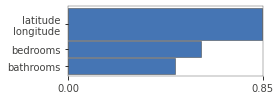

In [9]:
showimp(rf, X, y)

### Feature Importance

Many times, a model's ability to generalize (predict) well is not all we are hoping for; we would also like to understand what the model is doing, which is referred to as a model's interpretability. Random Forests have this as a built in feature, however the implementation in *sklearn* suffers from bias when:
- the scales of the features vary; and/or, 
- there are many categories for a feature.

A better way to assess feature importance, in any model, is to use:
- permutation importance; or 
- dropped feature importance.

##### Permutation Importance

We can calculate the feature importances using a permutation method, which consists of the following steps:
- use all features and establish a baseline value for $R^2$;
- select one feature and randomly permute its values leaving all other features unchanged;
- calculate the new value for $R^2$ with this one feature permuted;
- calculate the change in $R^2$ from the baseline; and, 
- repeat for the other features.

Let's see how this works.

In [10]:
def perm_importances(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True, random_state=999)
    rf.fit(X, y)
    r2 = rf.oob_score_
    print(f"Baseline R^2 with no columns permuted: {r2:.5f}\n")
    for col in X.columns:
        X_col = X.copy()
        X_col[col] = X_col[col].sample(frac=1).values
        rf.fit(X_col, y)
        r2_col = rf.oob_score_
        print(f"Permuting column {col}: new R^2 is {r2_col:.5f} and difference from baseline is {r2 - r2_col:.5f}")


In [11]:
perm_importances(X, y)

Baseline R^2 with no columns permuted: 0.86763

Permuting column bathrooms: new R^2 is 0.81311 and difference from baseline is 0.05452
Permuting column bedrooms: new R^2 is 0.75357 and difference from baseline is 0.11406
Permuting column longitude: new R^2 is 0.68464 and difference from baseline is 0.18298
Permuting column latitude: new R^2 is 0.68668 and difference from baseline is 0.18095


##### Dropped Column Importance

We can also calculate the importance of the features using a dropped column, which consists of the following steps:
- use all features and establish a baseline value for $R^2$;
- select one feature and remove it from the data;
- calculate the new value for $R^2$ with this one feature removed;
- calculate the change in $R^2$ from the baseline; and, 
- repeat for the other features.

Let's see how this works.

In [12]:
def drop_importances(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True, random_state=999)
    rf.fit(X, y)
    r2 = rf.oob_score_
    print(f"Baseline R^2 with no columns dropped: {r2:.5f}\n")
    for col in X.columns:
        X_col = X.copy()
        X_col = X_col.drop(col, axis=1) 
        rf.fit(X_col, y)
        r2_col = rf.oob_score_
        print(f"Dropping column {col}: new R^2 is {r2_col:.5f} and difference from baseline is {r2 - r2_col:.5f}")

In [13]:
drop_importances(X, y)

Baseline R^2 with no columns dropped: 0.86763

Dropping column bathrooms: new R^2 is 0.81941 and difference from baseline is 0.04821
Dropping column bedrooms: new R^2 is 0.77719 and difference from baseline is 0.09044
Dropping column longitude: new R^2 is 0.73451 and difference from baseline is 0.13311
Dropping column latitude: new R^2 is 0.74144 and difference from baseline is 0.12619


##### Be Careful With Correlation

In [14]:
X_dup = X.copy()
X_dup['bedrooms_dup'] = X_dup['bedrooms']
X_dup.head()

,bathrooms,bedrooms,longitude,latitude,bedrooms_dup
0,1.0,1,-73.9539,40.7108,1
1,1.0,2,-73.9722,40.7513,2
2,1.0,2,-73.9625,40.7575,2
3,1.5,3,-73.9425,40.7145,3
4,1.0,0,-73.9743,40.7439,0


In [15]:
drop_importances(X_dup, y)

Baseline R^2 with no columns dropped: 0.86736

Dropping column bathrooms: new R^2 is 0.81960 and difference from baseline is 0.04776
Dropping column bedrooms: new R^2 is 0.86764 and difference from baseline is -0.00027
Dropping column longitude: new R^2 is 0.73442 and difference from baseline is 0.13294
Dropping column latitude: new R^2 is 0.74139 and difference from baseline is 0.12597
Dropping column bedrooms_dup: new R^2 is 0.86763 and difference from baseline is -0.00026


##### Breaking Correlation

In [16]:
noise = np.random.normal(0, 2, X_dup.shape[0])

X_dup['bedrooms_dup'] = X_dup['bedrooms'] + noise
X_dup.head()

,bathrooms,bedrooms,longitude,latitude,bedrooms_dup
0,1.0,1,-73.9539,40.7108,0.808281
1,1.0,2,-73.9722,40.7513,-0.015214
2,1.0,2,-73.9625,40.7575,2.911445
3,1.5,3,-73.9425,40.7145,9.562779
4,1.0,0,-73.9743,40.7439,1.702281


In [17]:
drop_importances(X_dup, y)

Baseline R^2 with no columns dropped: 0.84715

Dropping column bathrooms: new R^2 is 0.78743 and difference from baseline is 0.05972
Dropping column bedrooms: new R^2 is 0.72391 and difference from baseline is 0.12324
Dropping column longitude: new R^2 is 0.67930 and difference from baseline is 0.16785
Dropping column latitude: new R^2 is 0.68463 and difference from baseline is 0.16252
Dropping column bedrooms_dup: new R^2 is 0.86763 and difference from baseline is -0.02048
